# Entrenamiento de modelo



In [1]:
# Bibliotecas

import pandas as pd
import joblib

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
# from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definiciones globales

%run ../Lib/pandas_options.py
%run ../Lib/define_constantes.py

In [3]:
# Cargar datos ya preprocesados y dividirlos en variables independientes (X) y variable dependiente objetivo (Y)

archivo_datos_codificados = f'{DIRECTORIO_RESULTADOS}/DATOSCODIFICADOS.csv'
df_datos_codificados = pd.read_csv(archivo_datos_codificados, low_memory=False)

X = df_datos_codificados.drop('DETERIORADO', axis='columns')
Y = df_datos_codificados['DETERIORADO']

print('\nVariables de entrada (X):')
print(f'{len(X.columns)} columnas:\n{X.columns.to_list()}')
print('-' * 92)
print('\nVariable dependiente (Y):')
print(Y.info())
print(Y.value_counts().sort_index())


Variables de entrada (X):
20 columnas:
['EDAD', 'DIAMETRO', 'LONGITUD', 'AREA', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'ARRANQUE', 'ZONA_SUR', 'MUNICIPIO_MEDELLIN', 'ESTADO_OPERACION', 'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_LLUVIAS Y DESCARGAS', 'TIPO_AGUA_OTRAS', 'MATERIAL_CONCRETO REFORZADO Y OTROS', 'MATERIAL_CONCRETO SIMPLE', 'MATERIAL_PVC', 'FABRICANTE_INDUSTRIAS DIQUE S.A.', 'FABRICANTE_MEXICHEM COLOMBIA S.A.S.', 'FABRICANTE_OTROS']
--------------------------------------------------------------------------------------------

Variable dependiente (Y):
<class 'pandas.core.series.Series'>
RangeIndex: 25674 entries, 0 to 25673
Series name: DETERIORADO
Non-Null Count  Dtype
--------------  -----
25674 non-null  bool 
dtypes: bool(1)
memory usage: 25.2 KB
None
DETERIORADO
False    14246
True     11428
Name: count, dtype: int64


In [4]:
# Entrenar modelo

#modelo = LogisticRegression(C=5, class_weight={False: 1, True: 2}, max_iter=10000, n_jobs=-1, solver='newton-cholesky')
#modelo = LogisticRegression(C=0.1, class_weight={False: 1, True: 2}, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty='l1', solver='saga')
# modelo = RandomForestClassifier(ccp_alpha=0.1, class_weight={False: 1, True: 1.5},
#                        min_samples_leaf=2000, min_samples_split=10,
#                        n_estimators=10000, n_jobs=-1)
# modelo = SVC(C=20, class_weight={False: 1, True: 2})
# modelo = HistGradientBoostingClassifier(class_weight={False: 0.6978099115541204, True: 1}, early_stopping=False, l2_regularization=1, learning_rate=0.015, max_leaf_nodes=63, min_samples_leaf=5)
modelo = XGBClassifier()
params = {
    'device'           : 'gpu', 
    'eval_metric'      : 'logloss', 
    'learning_rate'    : 0.01, 
    'max_depth'        : 3, 
    'min_child_weight' : 0.05, 
    'n_jobs'           : -1, 
    'objective'        : 'binary:logistic', 
    'reg_lambda'       : 10, 
    'scale_pos_weight' : 1.3021900884458795, 
    'subsample'        : 0.5,
}
modelo.set_params(**params)

x_train, x_test, y_train, y_test = train_test_split(X, Y)
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

d:\Proyectos_VSCODE\Aguas_residuales\Modelo_deterioro_tramos-main\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
d:\Proyectos_VSCODE\Aguas_residuales\Modelo_deterioro_tramos-main\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:28:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       False       0.83      0.69      0.75      3550
        True       0.68      0.82      0.75      2869

    accuracy                           0.75      6419
   macro avg       0.76      0.76      0.75      6419
weighted avg       0.76      0.75      0.75      6419



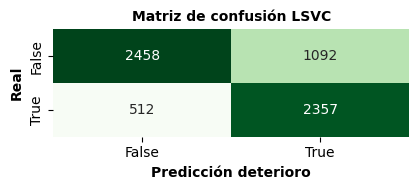

In [5]:
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = [False, True]
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción deterioro', fontweight='bold')
plt.ylabel('Real', fontweight='bold')
plt.title('Matriz de confusión LSVC', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# Ajuste de RECALL (Detección de positivos)

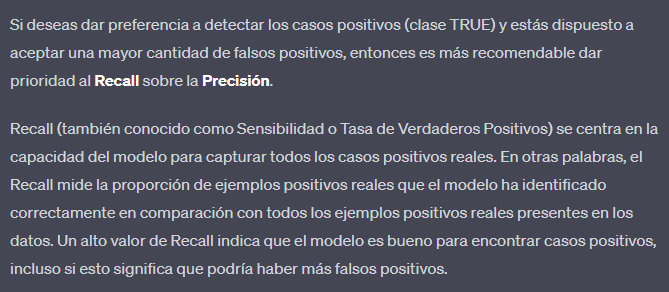

              precision    recall  f1-score   support

       False       0.83      0.69      0.75      3550
        True       0.68      0.82      0.75      2869

    accuracy                           0.75      6419
   macro avg       0.76      0.76      0.75      6419
weighted avg       0.76      0.75      0.75      6419



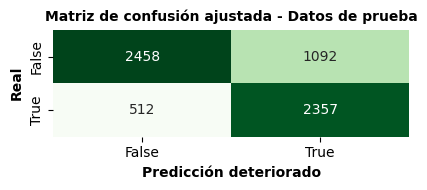

In [6]:
# Obtener las probabilidades estimadas
probabilities = modelo.predict_proba(x_test)[:, 1]  # Probabilidades de la clase positiva

# Definir umbral
threshold = 0.5 # Sin ajuste adicional para modelo XGBoost

# Obtener las predicciones ajustadas después de ajustar el umbral de decisión
adjusted_predictions = (probabilities > threshold).astype(int)

# Generar el classification_report con las nuevas predicciones ajustadas
report = classification_report(y_test, adjusted_predictions)

# Generar la matriz de confusión con las nuevas predicciones ajustadas
conf_matrix = confusion_matrix(y_test, adjusted_predictions)

# Imprimir el classification_report y la matriz de confusión
print(report)
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción deteriorado', fontweight='bold')
plt.ylabel('Real', fontweight='bold')
plt.title('Matriz de confusión ajustada - Datos de prueba', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


In [7]:
# Guardar modelo entrenado

archivo_modelo = f'{DIRECTORIO_MODELOS}/modelo.joblib'
joblib.dump(modelo, archivo_modelo)
print(f'Guardado modelo en {archivo_modelo}')

Guardado modelo en ../Modelos/modelo.joblib


In [8]:
# Guardar columnas usadas

columnas_modelo = X.columns.to_list()
archivo_columnas = f'{DIRECTORIO_MODELOS}/COLUMNAS.txt'

with open(archivo_columnas, "w") as archivo:
    for col in columnas_modelo:
        archivo.write(col + '\n')

print(columnas_modelo)

['EDAD', 'DIAMETRO', 'LONGITUD', 'AREA', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'ARRANQUE', 'ZONA_SUR', 'MUNICIPIO_MEDELLIN', 'ESTADO_OPERACION', 'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_LLUVIAS Y DESCARGAS', 'TIPO_AGUA_OTRAS', 'MATERIAL_CONCRETO REFORZADO Y OTROS', 'MATERIAL_CONCRETO SIMPLE', 'MATERIAL_PVC', 'FABRICANTE_INDUSTRIAS DIQUE S.A.', 'FABRICANTE_MEXICHEM COLOMBIA S.A.S.', 'FABRICANTE_OTROS']
